# Producing unsupervised analysis of days of week (step by step)

Treating bridge crossings each day as features to learn about the relationships between various days.

This notebok is a re-run of the tutorial analysis by [Jake Vanderplas](https://github.com/jakevdp/JupyterWorkflow) with an updated data set.

## 0. Python packages

It's a custom to put the imported/required all at the top of the notebook like so: 

```python
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
```
But for the purposes of going with the workflow I'll leave them at the points below at which they were imported.

## 1. Data

### 1.1 Access to data so that the analysis is reproducible

In [1]:
URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

In [2]:
from urllib.request import urlretrieve
urlretrieve(URL, 'Fremont.csv')

('Fremont.csv', <http.client.HTTPMessage at 0x106672748>)

### 1.2 Formatting data

In [3]:
import pandas as pd
data = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


#### 1.2.1 Creating a function for loading data

So that we don't have to download the file every time (if we have it alrady), we can create this function instead:

```python
import os
from urllib.request import urlretrieve

import pandas as pd

FREMONT_URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'


def get_fremont_data(filename='Fremont.csv', url=FREMONT_URL,
                     force_download=False):
    """Download and cache the fremont data
    Parameters
    ----------
    filename : string (optional)
        location to save the data
    url : string (optional)
        web location of the data
    force_download : bool (optional)
        if True, force redownload of data
    Returns
    -------
    data : pandas.DataFrame
        The fremont bridge data
    """
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
    data = pd.read_csv(filename, index_col='Date')

    try:
        data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    except TypeError:
        data.index = pd.to_datetime(data.index)

    data.columns = ['West', 'East']
    data['Total'] = data['West'] + data['East']
    return data
```


- We will need to import 'os' to check whether we have the file on our os (is that what it is?)
- We will need to import 'urlretrieve' to retrieve the file if we don't have it
- We will need to import pandas and format the data 'read_csv' as before
- "force_download" is there if we want to force the download (e.g. data set has been updated). So the function says if we force the download or we don't have the file go and download it.

#### 1.2.1.1 We can put the above function into a Python package

This will allow us to use it in another notebook, for example. [Jake's tutorial.](https://www.youtube.com/watch?v=DjpCHNYQodY&t=342s)

The code then looks like this:

```python
from packages.data import get_fremont_data
```
Where packages.data = folder_name.file_name we chose for the package.

### 1.3 Visual data analysis

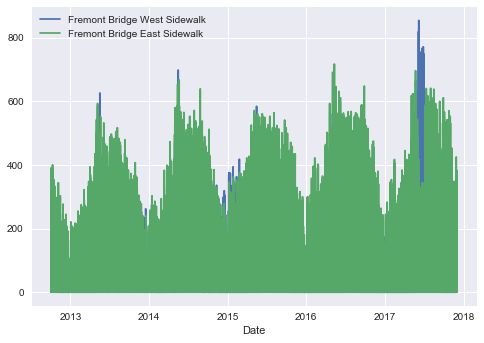

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn') # We can choose from matplotlib style library
data.plot()

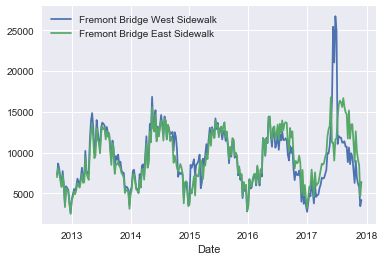

In [5]:
# Resampling the data by weekly sum as the above plot is too dense 
data.resample('W').sum().plot()

# And we can change the legend to simplify it
data.columns = ['West', 'East']

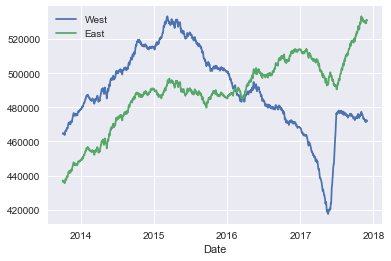

In [6]:
# Rolling sum over 365 days (represented by the 'D') - the the two '.sum()' in the code
data.resample('D').sum().rolling(365).sum().plot()

(0, 539167.19999999995)

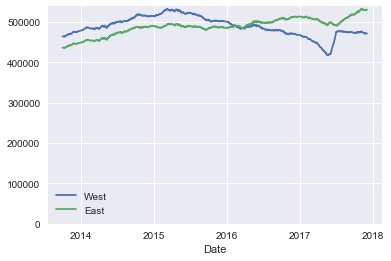

In [7]:
# Same chart as above, but...
ax = data.resample('D').sum().rolling(365).sum().plot()

# Change the y axis to zero so that it doesn't exaggerate the trends
ax.set_ylim(0, None)

(0, 1059460.05)

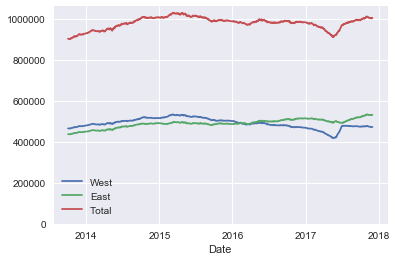

In [8]:
# Add total

data['Total'] = data['West'] + data['East']

ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

#### 1.3.1 Take a look at the trend within individual days

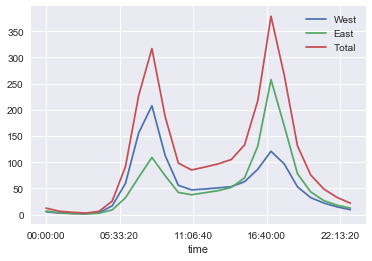

In [9]:
# Group by time of day, then take the mean, and plot it
# This will be the average of crossings of the bridge on time of day throughout the year
data.groupby(data.index.time).mean().plot()

The chart above is indicative of commuting pattern of people crossing the bridge: 

 - West side of the bridge peaks in the morning - into the city
 - East side of the bridge peaks in the acternoon - back from the city
 - Total peaks in rush hour times

#### 1.3.2 Seeing the full data set

Let's see the whole data set in the same way as the sums above.

In [10]:
# The arguments inside the pivot_table (method?)
# Total: we want the total counts as values
# index (i.e. columns) is the time from our data.index column (remember, we imported the csv with: index_col='Date')
# columns = dates from our data.index column
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)

# Let's look at the first five by five blocks of the pivoted table
pivoted.iloc[:5,:5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


We now have a two dimensional data frame where each column is a day in the data set and each row corresponds to an hour during that day.

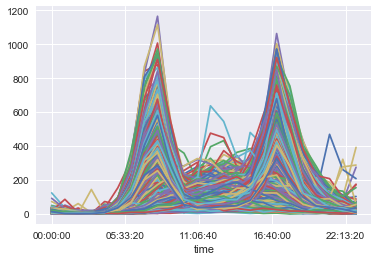

In [11]:
# Let's look at that data without the legent in the plot
pivoted.plot(legend=False)

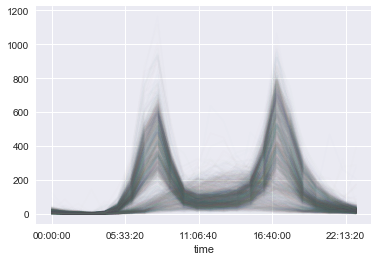

In [12]:
# Above we have a line for each day in each year so it's hard to see any patterns
# So let's introduce some transparency to the lines with the alpha= parameter

pivoted.plot(legend=False, alpha=0.01)

Now we can see thanks to the transparency in the lines that some commutes have the "two spikes" pattern but also a bunch of days that do NOT have that pattern, they peak mid-day instead.

In [13]:
pivoted.shape

(24, 1885)

In [14]:
# Transposed pivot shape - i.e. swapping the axes
pivoted.T.shape

(1885, 24)

## 2. Principal Component Analysis

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

We can view the data as 1885 observations and each observation has 24 hours.

We'll use scikit.learn to do PCA 

In [15]:
from sklearn.decomposition import PCA
PCA(2)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
# Now we need to get the pivoted data into numpy array from this pivoted.T.shape to
X = pivoted.T.values
X.shape

(1885, 24)

In [17]:
# Simply PCA(2).fit(x) produces an error:
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
# So we need to alter this x = pivoted.T.values so that "no values" are zero

X = pivoted.fillna(0).T.values

# This worked for me but not in the video PCA(2).fit(x)
# So he added another parameter to it PCA(2, svd_solver='dense').fit(x) - but 'dense' was actually the wrong parameter anyway.
# But that didn't work for me because it looks like they've altered the package by adding svd_solver='auto'

PCA(2).fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# It doesn't work without the '_transform' part in it! X2 has no attribute shape without the transformation.

X2 = PCA(2, svd_solver='full').fit_transform(X)
X2.shape

(1885, 2)

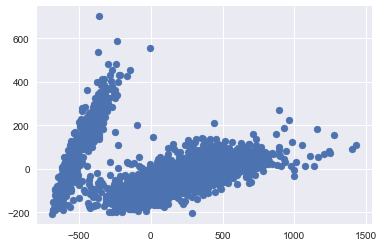

In [19]:
plt.scatter(X2[:,0], X2[:,1])

## 3. Unsupervised Clustering

We'll use Gaussian mixture model.

In [20]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)
labels

array([1, 1, 1, ..., 1, 1, 1])

The 0s and 1s in the array are representing the two clusters.

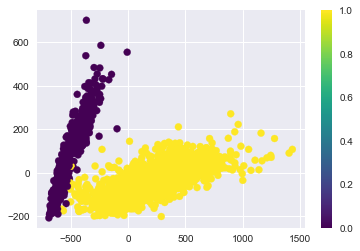

In [21]:
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='viridis')
plt.colorbar()

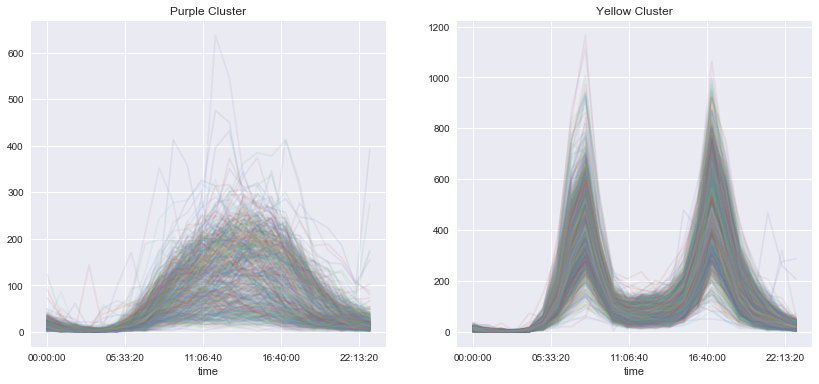

In [22]:
# Putting the two charts on the same line
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# [labels == 0] means that these are only the data from one (of the two clusters, the other value is 1)
# The (legend=False, alpha=0.01) is there because we have too many lines otherwise
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0]);
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1]);

# Adding headers
ax[0].set_title('Purple Cluster')
ax[1].set_title('Yellow Cluster');

## 4. Comparing with Day of Week

In [23]:
pivoted.columns

Index([2012-10-03, 2012-10-04, 2012-10-05, 2012-10-06, 2012-10-07, 2012-10-08,
       2012-10-09, 2012-10-10, 2012-10-11, 2012-10-12,
       ...
       2017-11-21, 2017-11-22, 2017-11-23, 2017-11-24, 2017-11-25, 2017-11-26,
       2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30],
      dtype='object', length=1885)

In [24]:
# we want to convert the dates to days of week

pd.DatetimeIndex(pivoted.columns)

DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-06',
               '2012-10-07', '2012-10-08', '2012-10-09', '2012-10-10',
               '2012-10-11', '2012-10-12',
               ...
               '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24',
               '2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', length=1885, freq=None)

In [25]:
# because DatetimeIndex has an attribute 'dayofweek'

pd.DatetimeIndex(pivoted.columns).dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=1885)

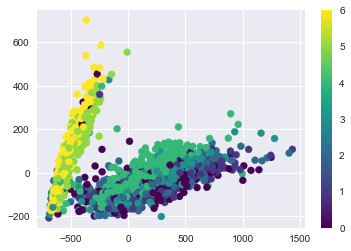

In [26]:
# Let's save the dayofweek as a shorthand 
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

# As the scatter plot before but change color from c=labels to c=dayofweek
plt.scatter(X2[:,0], X2[:,1], c=dayofweek, cmap='viridis')
plt.colorbar()

## 5. Analysing Outliers

The following points are weekdays with weekend pattern. Are they holidays?

In [27]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 1) & (dayofweek < 5)]

DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-08',
               '2012-10-09', '2012-10-10', '2012-10-11', '2012-10-12',
               '2012-10-15', '2012-10-16',
               ...
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-20',
               '2017-11-21', '2017-11-22', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', length=1301, freq=None)

Yes, they are holiday days and one snowstorm shutdown day.